<a href="https://colab.research.google.com/github/KAREN154/PlantPathoDetect-/blob/main/Tomato_Classification_Mobile_Net%26_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


####Building A CNN Model to Classify Tomato Images
>Tomato plants can exhibit various diseases and deficiencies that affect crop yield and quality. Accurately categorizing tomato plant conditions through leaf images is essential for effective crop management and disease control. By leveraging CNNs, the classification process can be automated, significantly improving the efficiency and accuracy of disease detection and plant health monitoring strategies.
CNNs excel at image analysis and feature extraction, allowing them to capture intricate details and patterns from tomato leaf images in the dataset.

**The convolutional layers in CNNs are able to identify:**
- Leaf color variations
- Spot patterns and lesions
- Texture changes
- Leaf venation patterns
- Disease-specific markings
- Nutrient deficiency symptoms

>These features enable the network to learn and distinguish between different tomato plant conditions. The pooling layers nested throughout the architecture down-sample the produced feature maps, allowing models to generalize leaf characteristics across different:

- Lighting conditions
- Leaf orientations
- Growth stages
- Image angles
- Environmental factors

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 33315 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Epoch 1/3
4165/4165 ━━━━━━━━━━━━━━━━━━━━ 2657s 635ms/step - accuracy: 0.7366 - loss: 0.7201 - val_accuracy: 0.8461 - val_loss: 0.4164 - learning_rate: 0.0010
Epoch 2/3
4165/4165 ━━━━━━━━━━━━━━━━━━━━ 525s 126ms/step - accuracy: 0.8368 - loss: 0.4446 - val_accuracy: 0.8758 - val_loss: 0.3349 - learning_rate: 0.0010
Epoch 3/3
4165/4165 ━━━━━━━━━━━━━━━━━━━━ 579s 130ms/step - accuracy: 0.8600 - loss: 0.3839 - val_accuracy: 0.8689 - val_loss: 0.3525 - learning_rate: 0.0010
Found 280 images belonging to 6 classes.
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.8911 - loss: 0.2682
Test Accuracy: 0.89


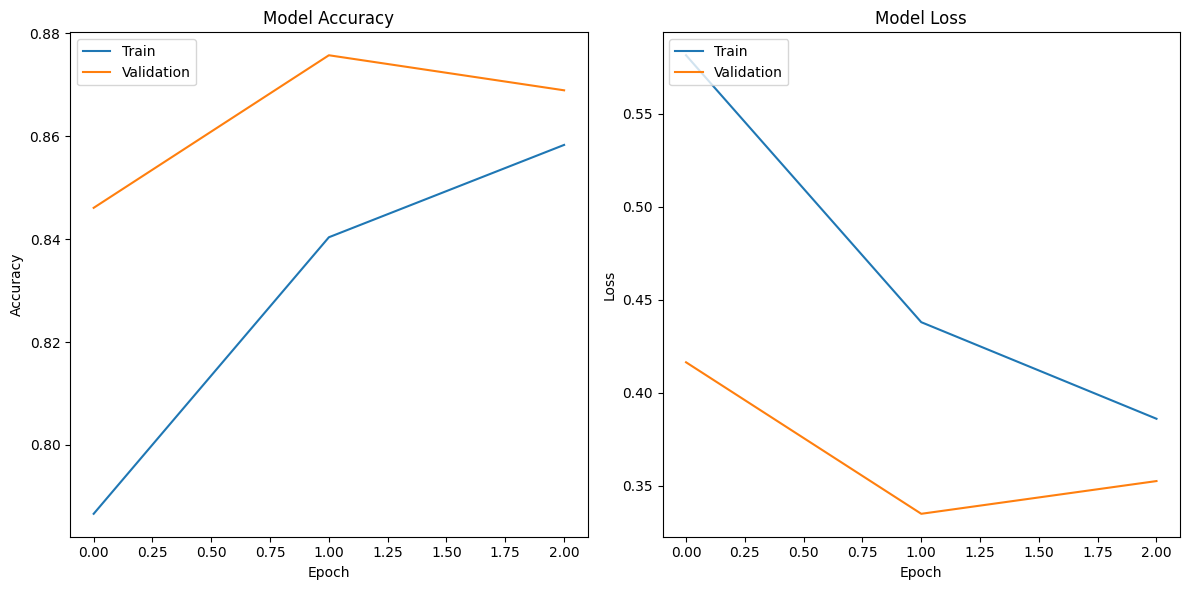

In [ ]:
# Ensure all required libraries are imported
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

class MobileNetV2Model:
    def __init__(self, input_shape=(96, 96, 3), num_classes=6):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        # Load MobileNetV2 pre-trained on ImageNet
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom layers
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)

        # Create the model
        self.model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def train_model(self, train_dir, val_dir, batch_size=8, epochs=3):
        if self.model is None:
            self.build_model()

        IMAGE_SIZE = self.input_shape[:2]

        # Data augmentation for training data
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.05,
            zoom_range=0.05,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )
        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            patience=1,
            factor=0.5,
            min_lr=1e-6
        )

        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[early_stopping, reduce_lr]
        )

    def evaluate_model(self, test_dir, batch_size=8):
        if self.model is None:
            raise ValueError("Model has not been built yet. Call build_model() first.")

        IMAGE_SIZE = self.input_shape[:2]
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        test_loss, test_accuracy = self.model.evaluate(test_generator)
        print(f'Test Accuracy: {test_accuracy:.2f}')
        return test_loss, test_accuracy

    def plot_training_history(self):
        if self.history is None:
            print("No training history found. Please train the model first.")
            return

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()


# Instantiate the model
model = MobileNetV2Model()

# Build the model
model.build_model()

# Define directories
train_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Train_augmented'
val_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Val'
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Test'

# Train the model
model.train_model(train_dir, val_dir)

# Evaluate the model after training
model.evaluate_model(test_dir)

# Plot the training history
model.plot_training_history()


In [ ]:
# After training the model, save it to a file
model.model.save('Tomato_mobilenetv2_model.h5')


In [ ]:
# Save the trained model using the recommended native Keras format
model.model.save('Tomato_inception_model.keras')


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Load the trained model
model = load_model('Tomato_mobilenetv2_model.h5')

# Define image size and batch size - This should match the input shape of the model
IMAGE_SIZE = (96, 96) # Changed from (224, 224) to (96, 96)

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes
# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 642ms/step
Weighted F1 Score: 0.89
                        precision    recall  f1-score   support

        Bacterial Spot       0.95      0.93      0.94        43
          Early Blight       0.77      0.83      0.80        48
               Healthy       0.98      0.94      0.96        49
           Late Blight       0.93      0.81      0.86        47
    Septoria Leaf Spot       0.77      0.93      0.85        44
Yellow Leaf Curl Virus       1.00      0.92      0.96        49

              accuracy                           0.89       280
             macro avg       0.90      0.89      0.89       280
          weighted avg       0.90      0.89      0.89       280



In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

class DenseNet121Model:
    def __init__(self, input_shape=(32, 32, 3), num_classes=6):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze all layers of DenseNet to use it purely as a feature extractor
        for layer in base_model.layers:
            layer.trainable = False

        # Custom classification layers
        x = base_model.output
        x = GlobalAveragePooling2D()(x)  # Pool the feature maps
        x = Dense(64, activation='relu')(x)  # Reduced to fewer units
        x = Dropout(0.3)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)

        # Compile the model
        self.model = Model(inputs=base_model.input, outputs=predictions)
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self, train_dir, val_dir, batch_size=64, epochs=3, steps_per_epoch=50):
        IMAGE_SIZE = self.input_shape[:2]

        # Simple data augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )
        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Callbacks to stop early if performance plateaus
        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1)

        # Train the model with fewer steps per epoch
        self.history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

    def evaluate_model(self, test_dir, batch_size=64):
        IMAGE_SIZE = self.input_shape[:2]
        test_datagen = ImageDataGenerator(rescale=1./255)

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        test_loss, test_accuracy = self.model.evaluate(test_generator)
        print(f'Test Accuracy: {test_accuracy:.2f}')
        return test_loss, test_accuracy

    def plot_training_history(self):
        if self.history:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['accuracy'])
            plt.plot(self.history.history['val_accuracy'])
            plt.title('Model Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['loss'])
            plt.plot(self.history.history['val_loss'])
            plt.title('Model Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')

            plt.tight_layout()
            plt.show()
        else:
            print("No training history found. Please train the model first.")

# Instantiate the model
densenet_model = DenseNet121Model()
densenet_model.build_model()

# Train and evaluate the model
train_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Train_augmented'
val_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Val'
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Test'

densenet_model.train_model(train_dir, val_dir, batch_size=32, epochs=8, steps_per_epoch=100)
densenet_model.evaluate_model(test_dir)


Found 33315 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 2096s 21s/step - accuracy: 0.3313 - loss: 1.7221 - val_accuracy: 0.6188 - val_loss: 1.0266 - learning_rate: 0.0010
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 750s 8s/step - accuracy: 0.5360 - loss: 1.2104 - val_accuracy: 0.6749 - val_loss: 0.9088 - learning_rate: 0.0010
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 680s 7s/step - accuracy: 0.5828 - loss: 1.1205 - val_accuracy: 0.6653 - val_loss: 0.8687 - learning_rate: 0.0010
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 669s 7s/step - accuracy: 0.6095 - loss: 1.0301 - val_accuracy: 0.7018 - val_loss: 0.7841 - learning_rate: 0.0010
Epoch 5/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.6308 - loss: 0.9806 - val_accuracy: 0.7170 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 6/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.6333 - loss: 0.9682 - val_accuracy: 0.7170 - val_loss: 0.7563 - learning_rate: 0.0010
E

(0.7022579312324524, 0.7321428656578064)

In [ ]:
# Evaluate the model
densenet_model.evaluate_model(test_dir, batch_size=32)

Found 280 images belonging to 6 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7318 - loss: 0.6713
Test Accuracy: 0.73


(0.7022577524185181, 0.7321428656578064)

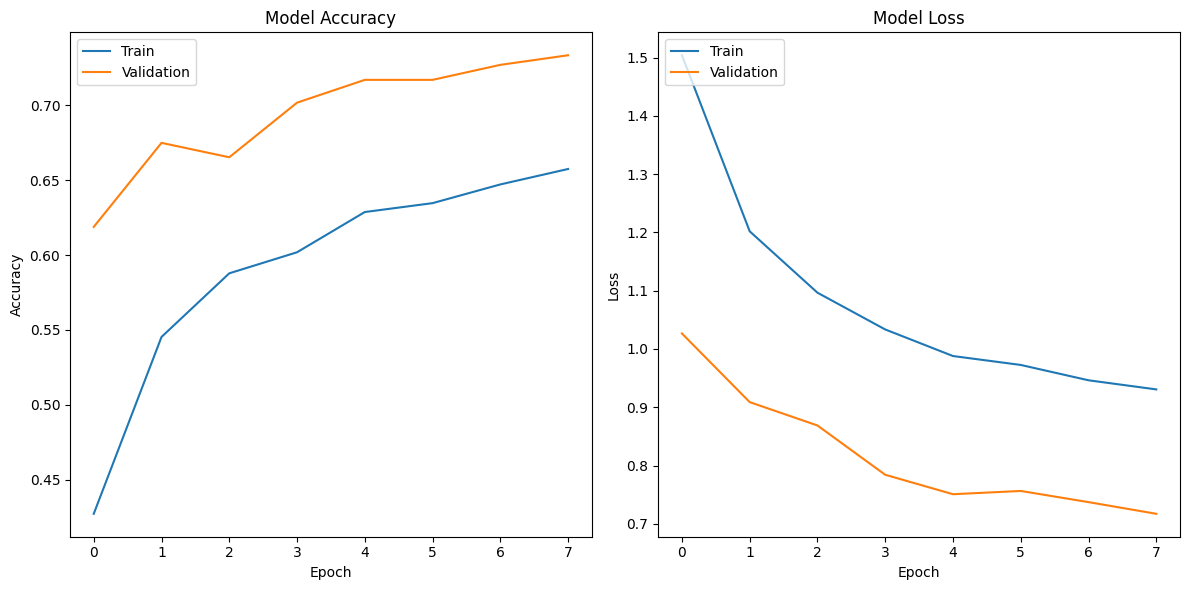

In [ ]:
# Plot the training history
densenet_model.plot_training_history()

In [ ]:
densenet_model.model.save('tomato_waste_classification_densenet_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('tomato_waste_classification_densenet_model.h5')

# Define image size and batch size
# The IMAGE_SIZE should match the input shape used during training (32, 32)
IMAGE_SIZE = (32, 32)  # Changed from (224, 224) to (32, 32)
BATCH_SIZE = 32

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
Weighted F1 Score: 0.72
                        precision    recall  f1-score   support

        Bacterial Spot       0.82      0.65      0.73        43
          Early Blight       0.66      0.44      0.53        48
               Healthy       0.83      1.00      0.91        49
           Late Blight       0.68      0.64      0.66        47
    Septoria Leaf Spot       0.71      0.80      0.75        44
Yellow Leaf Curl Virus       0.68      0.86      0.76        49

              accuracy                           0.73       280
             macro avg       0.73      0.73      0.72       280
          weighted avg       0.73      0.73      0.72       280

